<a href="https://colab.research.google.com/github/arac22/keras-demo/blob/main/posital_on_boom_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility functions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


In [2]:


# convert hex string to unsigned int (es. FF00 -> 65280)
def hex2int_unsigned(hex_val):
    return int(hex_val,16)

# convert hex string to signed int (es. FF00 -> -256)
def hex2int_signed(hexval):
    bits = 16
    val = int(hexval, bits)
    if val & (1 << (bits-1)):
        val -= 1 << bits
    return val


# read text file into pandas DataFrame
def load_trc_file(file_name, skip_rows, n_rows = None):
    data_frame = pd.read_csv(
        file_name,
        delim_whitespace=True, 
        skiprows = skip_rows, 
        header=None, 
        names=["N","O","T","B","I","d","R","L","D0","D1","D2","D3","D4","D5","D6","D7"],
        nrows= n_rows,
        index_col = 'O',
        converters={
            'O': partial(pd.to_datetime,unit='ms',infer_datetime_format=True)
            #    'D0': partial(int, base=16),
        }
        
    )
    return data_frame

# extract posital values
def get_posital_data(data_frame, message_id):
    
    df1 = data_frame[data_frame["I"] == message_id]

    # convert angle from hex bytes to unsigned int
    #df1['P2'] = (df1['D1'] + df1['D0']).apply(hex2int_unsigned)
    df1.loc[:,'P2'] = (df1.loc[:,'D1'] + df1.loc[:,'D0']).apply(hex2int_unsigned)

    # resample at 10 milliseconds
    df1 = df1.resample("10L").ffill()

    return df1


def get_joystick_data(data_frame, message_id):
    # command = df[df["I"] == '02B2']
    df1 = data_frame[data_frame["I"] == message_id]

    # convert set points from hex strings to signed int
    #df1['C2'] = (df1['D1'] + df1['D0']).apply(hex2int_signed)
    #df1['C1'] = (df1['D3'] + df1['D2']).apply(hex2int_signed)
    df1.loc[:,'C2'] = (df1.loc[:,'D1'] + df1.loc[:,'D0']).apply(hex2int_signed)
    df1.loc[:,'C1'] = (df1.loc[:,'D3'] + df1.loc[:,'D2']).apply(hex2int_signed)

    # resample at 10 milliseconds
    df1 = df1.resample("10L").ffill()

    return df1


def merge_columns(cmd, pos, cmd_rolling_length = 1, pos_rolling_length = 1):

    min_rows = min(cmd.shape[0], pos.shape[0])

    #cmd = cmd[['C1','C2']].iloc[0:min_rows].copy()
    cmd = cmd.loc[:,('C1','C2')].iloc[0:min_rows].copy()
    
    cmd = cmd.rolling(cmd_rolling_length).mean()

    #pos = pos[['P2']].iloc[0:min_rows].copy()
    pos = pos.loc[:,'P2'].iloc[0:min_rows].copy()
    
    pos = pos.rolling(pos_rolling_length).mean()

    df1 = pd.merge(cmd, pos, left_index=True, right_index=True)
    df1 = df1.dropna()

    return df1

def plot_joystick_and_position(df1):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()

    df1.plot(y=['P2'], ax=ax)
    df1.plot(y=["C1", "C2"], ax=ax2, ls="--")

    plt.show()


# constants
C1_BASE = 3  # start from columns 3
C1_STEP = 3  # take 3 steps back
C1_SIZE = 33 # was 33 in the ETH model

C2_BASE = C1_BASE+C1_SIZE  # start from columns 3+5
C2_STEP = 3  # take 3 steps back
C2_SIZE = 33 # was 33 in the ETH model


V_BASE = C1_BASE+C1_SIZE+C2_SIZE 
V_STEP = 1 # take 1 step back
V_SIZE = 10 # was 10 in the ETH model

def augment_columns(df3,velocity_filter_length = 1):
    # create columns with past commands
    for i in range(1,C1_SIZE+1):
        df3[C1_BASE+i] = df3['C1'].shift(i*C1_STEP)
        df3.rename(columns={C1_BASE+i:'C1-'+ str(i*C1_STEP)}, inplace=True)

    for i in range(1,C2_SIZE+1):
        df3[C2_BASE+i] = df3['C2'].shift(i*C2_STEP)
        df3.rename(columns={C2_BASE+i:'C2-'+ str(i*C2_STEP)}, inplace=True)

    # create velocities from positions
    df3['V2'] = df3['P2']-df3['P2'].shift(1)

    # filter velocities
    df3['V2'] = df3['V2'].rolling(velocity_filter_length).mean()

    # create delta velocities from velocities
    # df3['DV2'] = df3['V2']-df3['V2'].shift(1)

    # create columns with past velocities
    for i in range(1,V_SIZE+1):
        df3[V_BASE+i] = df3['V2'].shift(i*V_STEP)
        df3.rename(columns={V_BASE+i:'V2-'+ str(i*V_STEP)}, inplace=True) 
    
    df3 = df3.fillna(0)

    return df3


# utility function
def plot_loss(hist, ymax=100):
  plt.plot(hist.history['loss'], label='loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.ylim([0, ymax])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)


def plot_predictions_vs_labels(test_preds, test_lbls, max_value=30):
    a = plt.axes(aspect='equal')
    plt.scatter(test_lbls, test_preds)
    plt.xlabel('True Values [y]')
    plt.ylabel('Predictions [y]')
    lims = [0, max_value]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)


def plot_prediction_error(err):
    plt.hist(err, bins=25)
    plt.xlabel('Prediction Error [y]')
    _ = plt.ylabel('Count')

# Load training File

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load training file

In [27]:

# adjust training parameters

# data collection
# fname = "../input/posital-2-braccio/Posital 2 braccio.trc"
#fname = "../input/gru-dpx-posital-1-braccio-training/Gru_DPX_Posital_1_braccio_Training.trc"
#train_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Test_Andrea.trc"
#train_fname = "/data/workspace_files/Gru_DPX_Posital_1_braccio_Training_2022_10_18.trc"

train_fname = "/content/drive/MyDrive/Colab Notebooks/keras-demo/Gru_DPX_Posital_1_braccio_Training_2022_10_18.trc"

train_skip_rows = 20
train_n_rows = None

posital_message_id='0182'
joystick_message_id='02B1'

# data filter
joystick_rolling_length = 10
position_rolling_length = 10
train_velocity_rolling_length = 1

# keras model
labels_column_names = ['V2']
output_dimension = len(labels_column_names)
model_filename= './model_3'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


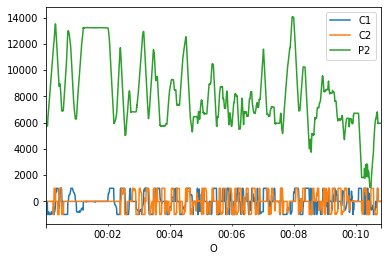

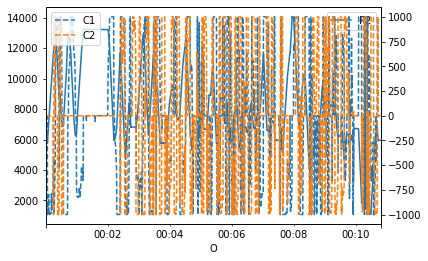

,C1,C2,P2
count,64767.000000,64767.000000,64767.000000
mean,-25.689749,13.238671,8146.725524
std,649.762083,645.027639,2666.429050
min,-1000.000000,-1000.000000,1070.600000
25%,-573.500000,-440.050000,6423.700000
50%,0.000000,0.000000,7561.200000
75%,476.250000,464.750000,9624.650000
max,1000.000000,1000.000000,14064.600000


In [28]:
# read text file into pandas DataFrame
df = load_trc_file(file_name=train_fname, skip_rows=train_skip_rows, n_rows=train_n_rows)

# extract posital rows
posital = get_posital_data(df, message_id=posital_message_id)

# extract joystick rows
joystick = get_joystick_data(df, message_id=joystick_message_id)

# merge and plot
train_df2 = merge_columns(joystick, posital, joystick_rolling_length, position_rolling_length)

train_df2.plot()
plot_joystick_and_position(train_df2)
train_df2.describe()

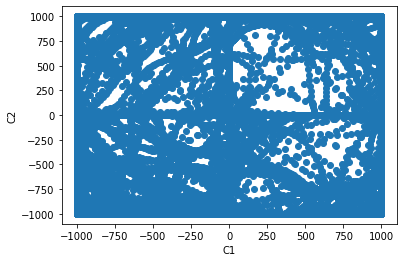

In [29]:
dd = train_df2.copy()
dd.drop('P2', axis=1)
plt.scatter(dd.C1, dd.C2)
plt.xlabel('C1')
plt.ylabel('C2')
plt.show()

# Train KERAS Model

## Train KERAS Model

In [30]:
# create additional columns
train_df3 = train_df2.copy()
keras_dataset = augment_columns(df3=train_df3, velocity_filter_length=train_velocity_rolling_length)

# split dataset in train and test
train_dataset = keras_dataset.sample(frac=0.8, random_state=0)
test_dataset = keras_dataset.drop(train_dataset.index)

# extract features and labels into separate arrays
train_features = train_dataset.copy()
train_features = train_features.drop(labels_column_names, axis=1)
train_labels = train_dataset.loc[:, labels_column_names]

test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

print(f'{test_labels.columns}, {test_features.columns}')

# create a Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)  # many variables
# normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None) #one variable

# set mean and std for Normalization layer
normalizer.adapt(np.array(train_features))
# print(normalizer.mean.numpy())

Index(['V2'], dtype='object'), Index(['C1', 'C2', 'P2', 'C1-3', 'C1-6', 'C1-9', 'C1-12', 'C1-15', 'C1-18',
       'C1-21', 'C1-24', 'C1-27', 'C1-30', 'C1-33', 'C1-36', 'C1-39', 'C1-42',
       'C1-45', 'C1-48', 'C1-51', 'C1-54', 'C1-57', 'C1-60', 'C1-63', 'C1-66',
       'C1-69', 'C1-72', 'C1-75', 'C1-78', 'C1-81', 'C1-84', 'C1-87', 'C1-90',
       'C1-93', 'C1-96', 'C1-99', 'C2-3', 'C2-6', 'C2-9', 'C2-12', 'C2-15',
       'C2-18', 'C2-21', 'C2-24', 'C2-27', 'C2-30', 'C2-33', 'C2-36', 'C2-39',
       'C2-42', 'C2-45', 'C2-48', 'C2-51', 'C2-54', 'C2-57', 'C2-60', 'C2-63',
       'C2-66', 'C2-69', 'C2-72', 'C2-75', 'C2-78', 'C2-81', 'C2-84', 'C2-87',
       'C2-90', 'C2-93', 'C2-96', 'C2-99', 'V2-1', 'V2-2', 'V2-3', 'V2-4',
       'V2-5', 'V2-6', 'V2-7', 'V2-8', 'V2-9', 'V2-10'],
      dtype='object')


In [31]:
# create keras model

dnn_model = keras.Sequential([
      normalizer,
      layers.Dense(units=128, activation='relu'),
      layers.Dense(units = 128, activation='relu'),
      layers.Dense(units=128, activation='relu'),
      layers.Dense(output_dimension)
  ])

dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 79)               159       
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               10240     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,552
Trainable params: 43,393
Non-trainable params: 159
________________________________________________

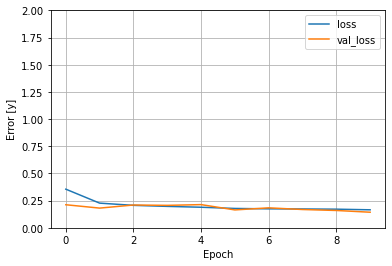

In [32]:
# train keras model

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=10
)

plot_loss(hist= history,ymax=2)

In [33]:
# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.1419903188943863

405/405 [==============================] - 1s 2ms/step


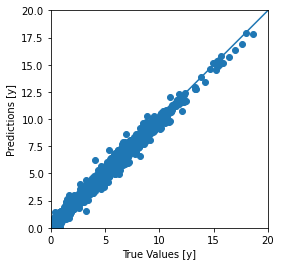

In [35]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)
plot_predictions_vs_labels(test_predictions, test_labels, max_value=20)
plt.show()



In [37]:
# evaluate predictions error

# DOES NOT WORK IN COLAB
#error = test_predictions - test_labels
#plot_prediction_error(error)
#plt.show()

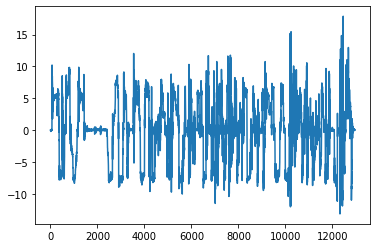

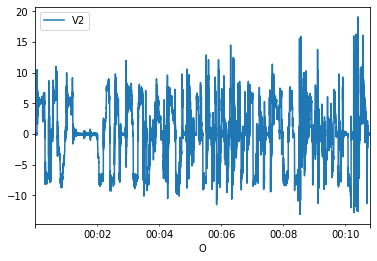

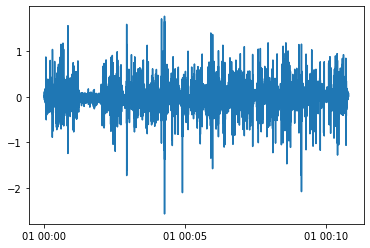

In [38]:
plt.plot(test_predictions), train_df3[labels_column_names].plot()
plt.show()
plt.plot(test_labels - test_predictions)

In [39]:
dnn_model.save(model_filename)
reloaded = tf.keras.models.load_model(model_filename)

# Load test file

## Load test file

In [40]:
# adjust these parameters

# data collection
test_fname = "/content/drive/MyDrive/Colab Notebooks/keras-demo/Gru_DPX_Posital_1_braccio_Test_Moussa_2022_10_18.trc"
test_skip_rows = 20
test_n_rows = None

test_velocity_rolling_length = train_velocity_rolling_length

In [41]:
# read text file into pandas DataFrame
df = load_trc_file(file_name=test_fname, skip_rows=test_skip_rows, n_rows=test_n_rows)
# print(df)

# extract posital rows
test_pos = get_posital_data(df, message_id=posital_message_id)

# extract joystick rows
test_joy = get_joystick_data(df, message_id=joystick_message_id)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


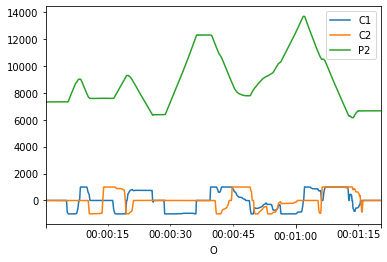

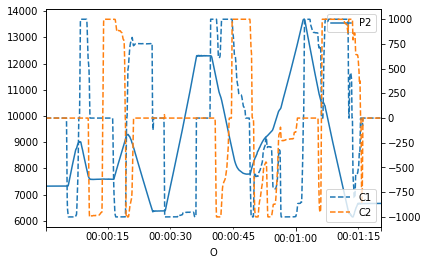

In [42]:
test_df2 = merge_columns(test_joy, test_pos, joystick_rolling_length, position_rolling_length)
test_df2.plot()
plot_joystick_and_position(test_df2)

# Evaluate test file

## Evaluate test file

In [43]:
# create additional columns
test_df3 = test_df2.copy()
keras_dataset = augment_columns(test_df3, velocity_filter_length=test_velocity_rolling_length )
print(keras_dataset)

                          C1   C2      P2  C1-3  C1-6  C1-9  C1-12  C1-15  \
O                                                                           
1970-01-01 00:00:00.120  0.0  0.0  7321.8   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:00:00.130  0.0  0.0  7321.8   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:00:00.140  0.0  0.0  7321.8   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:00:00.150  0.0  0.0  7321.8   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:00:00.160  0.0  0.0  7321.7   0.0   0.0   0.0    0.0    0.0   
...                      ...  ...     ...   ...   ...   ...    ...    ...   
1970-01-01 00:01:20.290  0.0  0.0  6661.3   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:01:20.300  0.0  0.0  6661.4   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:01:20.310  0.0  0.0  6661.5   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:01:20.320  0.0  0.0  6661.6   0.0   0.0   0.0    0.0    0.0   
1970-01-01 00:01:20.330  0.0  0.0  6661.7   0.0   0.0   0.0    0.0    0.0   

In [44]:
# use the whole file for testing, there is no training phase

# split dataset in train and test
test_dataset = keras_dataset.copy()

# extract features and labels into separate arrays
test_features = test_dataset.copy()
test_features = test_features.drop(labels_column_names, axis=1)
test_labels = test_dataset.loc[:, labels_column_names]

# evaluate model loss with test_data 
test_results = {}
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_results

0.1477300077676773

251/251 [==============================] - 0s 2ms/step


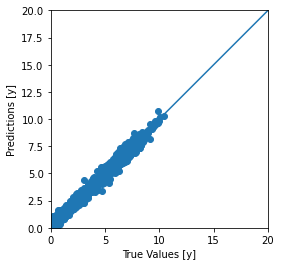

In [45]:
# compare test predictions with test labels
test_predictions = dnn_model.predict(test_features)
plot_predictions_vs_labels(test_predictions, test_labels, max_value=20)
plt.show()

# evaluate predictions error

# DOES NOT WORK IN COLAB
# error = test_predictions - test_labels
# plot_prediction_error(error)


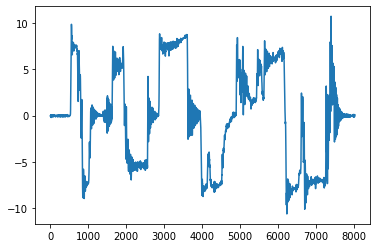

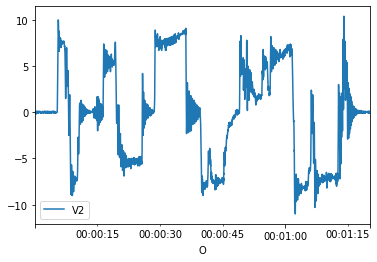

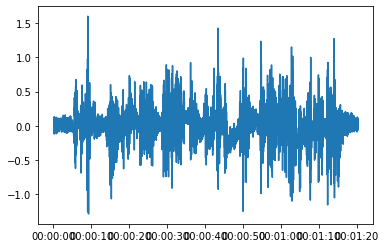

In [46]:
plt.plot(test_predictions),test_df3[labels_column_names].plot()
plt.show()
plt.plot(test_labels - test_predictions)

# Predict V2

In [47]:
import numpy as np
import pandas as pd
from collections import deque

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [48]:

# select model to be loaded
pred_model_filename = './model_3'

# load keras model
reloaded_model = tf.keras.models.load_model(pred_model_filename)

In [49]:
# create queues of size 33, 33 and 10
v2_zeros = np.zeros(V_SIZE*V_STEP)
c1_zeros = np.zeros(C1_SIZE*C1_STEP)
c2_zeros = np.zeros(C2_SIZE*C2_STEP)

v2_queue = deque(v2_zeros)
c1_queue = deque(c1_zeros)
c2_queue = deque(c2_zeros)

# create command input sequences 

# C1 impulse
c1_input = np.zeros(1000)
for i in range(200,600): c1_input[i] = 1000

# C2 always = zero
c2_input = np.zeros_like(c1_input)


# init position and velocity
cur_p2 = 10000
cur_v2 = 0

p2_history = []
v2_history = []


rr_base = 0
rr_size = 1000
rr = range(rr_base, rr_base + rr_size-1)


for pred_step in rr:

    print("=",end="")
    if (pred_step % 100 == 0):
        print(pred_step)

    p2_history.append(cur_p2)
    v2_history.append(cur_v2)

    cur_c1 = c1_input[pred_step + 1]
    cur_c2 = c2_input[pred_step + 1]

    # calculate next P2=P2 + V2
    cur_p2 = cur_p2 + cur_v2
    
    # build input data frame

    # take 10 velocities V2
    v2_list = list(v2_queue)

    # take 33 commands C1 (1 every 3 from last 100)
    c1_list = []
    for index,value in enumerate(c1_queue):
        if index in range(0, C1_SIZE*C1_STEP, C1_STEP):
            c1_list.append(value)

    # take 33 commands C2 (1 every 3 from last 100)
    c2_list = []
    for index,value in enumerate(c2_queue):
        if index in range(0, C2_SIZE*C2_STEP, C2_STEP):
            c2_list.append(value)

    # assemble list
    s = list([cur_c1,cur_c2,cur_p2]+c1_list + c2_list + v2_list)
    # print(s) 
    
    # transform in data frame
    qdf = pd.DataFrame(s).transpose()

    # make prediction 
    # cur_v2 = my_predict(qdf.transpose())
    pred_v2 = reloaded_model.predict(qdf, verbose=0)
    #print(pred_v2)

    cur_v2 = pred_v2[0][0]


    # store past values
    v2_queue.appendleft(cur_v2)
    v2_queue.pop()

    c1_queue.appendleft(cur_c1)
    c1_queue.pop()

    c2_queue.appendleft(cur_c2)
    c2_queue.pop()

=0
====================================================================================================100
====================================================================================================200
====================================================================================================300
====================================================================================================400
====================================================================================================500
====================================================================================================600
====================================================================================================700
====================================================================================================800
====================================================================================================900

In [50]:
v2_history[900]

-0.038158376

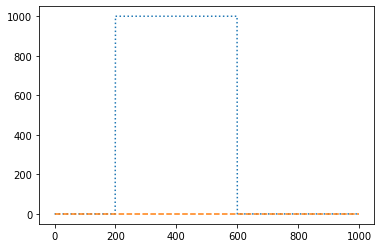

In [51]:
def plot_3(c1, c2, v2=None):
    plt.plot(c1, ls=":")
    plt.plot(c2, ls="--")
    
    if (v2):
        plt.plot(v2, ls="-.")

    plt.show()


plot_3(c1_input[rr_base:rr_base+rr_size], c2_input[rr_base:rr_base+rr_size])

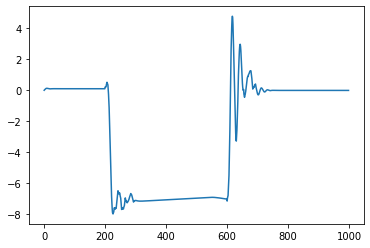

In [ ]:
plt.plot(v2_history)
plt.show()

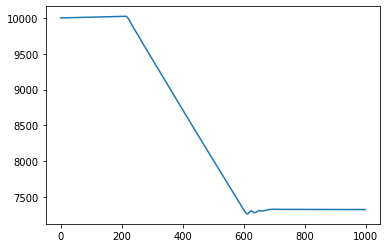

In [ ]:
plt.plot(p2_history)